# Import packages

In [1]:
import os
import numpy as np
# import ipdb
import time
from tqdm import tqdm
import datetime
import pandas as pd
import logging
from pathlib import Path
import matplotlib.pyplot as plt
import math

# torchvision for image loading
import torchvision
from torchvision import datasets, models
import torchvision.transforms.v2 as tr
import torchvision.transforms.v2.functional as trf

from torch.utils.data import DataLoader

# for transformations
import torchvision.transforms.v2 as tr
import torchvision.transforms.v2.functional as trf

# torch for model creation
import torch
import torch.nn as nn

# for model evaluation
import torcheval.metrics.functional as metf
from sklearn.metrics import precision_score, recall_score

#sklearn for data splitting
from sklearn.model_selection import train_test_split

import sys

sys.path.append(os.path.join(os.getcwd(), "Datasetting"))
from Setdata import EcoTaxaDataset, transform_vignettes_valid, FocalLoss, remove_missing_or_empty_images

sys.path.append(os.path.join(os.getcwd(), "PyramidNetPyTorch"))
from PyramidNet import PyramidNet

sys.path.append(os.path.join(os.getcwd(), "Loadingmodels"))
from Loading_models import initialize_model

sys.path.append(os.path.join(os.getcwd(), "Trainingmodels"))
from Training_models import train_model
from Find_best_lr import find_optimal_lr
from Create_confusion_matrix import log_confusion_matrix

# Auto lr finding
from torch_lr_finder import LRFinder

# Import mlflow dor data visualization
import mlflow


/home/coicaudtou/.conda/envs/Classification_UVP6_py310_v2/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Import Data

## Config

In [2]:
# Set mlflow
mlflow.set_tracking_uri("http://192.168.77.70:6000")

In [11]:
# root of the project
try:
    base_dir = Path(__file__).resolve().parent
except NameError:
    base_dir = Path("/home/coicaudtou/myspace/Classify_ANERIS")

# relative folders
data_dir = base_dir / "Data"
tsv_path = data_dir / "stacked_anerissmartbay_training.tsv"
output_root = base_dir / "Outputs" / "dataset_split"
train_dir = base_dir / "Outputs"/ "output_training"
log_dir = base_dir / "Outputs" / "log"
dataset_path = base_dir / "Outputs" / "datasets" 

RANDOM_STATE = 123

# prepare loggers
log = logging.getLogger()
log.setLevel(logging.INFO)

    # define the output format for log messages
log_formatter = logging.Formatter('%(asctime)s.%(msecs)03d\t%(message)s',\
                                  datefmt='%Y-%m-%dT%H:%M:%S')

    # log to console
console_handler = logging.StreamHandler()
console_handler.setFormatter(log_formatter)
log.addHandler(console_handler)

    # prepare logging to file (activated just before the training loop)
log_file = os.path.join(log_dir, 'log.tsv')
file_handler = logging.FileHandler(log_file)
file_handler.setFormatter(log_formatter)

## Splitting of the data

In [3]:
# ratios des splits
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2

# ---Charger les métadonnées
df = pd.read_csv(tsv_path, sep="\t", engine="python")
# Classes to exclude because they don't contain enough objects
other_to_live = [
    "reflection",
    "egg sac<egg",
    "t004",
    "Cnidaria<Metazoa",
    "Echinodermata"
]

# Classes to gather to the upper taxonomic group
recode_dict = {
    "Trisopterus minutus": "Actinopterygii",
    "Swima": "Annelida",
    "Syngnathiformes": "Actinopterygii",
    "Narcomedusae": "Hydrozoa",
    "Trachymedusae": "Hydrozoa",
    "Appendicularia": "house"
}

# Add to rare classes → "othertocheck"
recode_dict.update({k: "othertocheck" for k in other_to_live})

df = df[
    (df["img_rank"] == 100)
]

# Classes to gather
df["object_annotation_category"] = (
    df["object_annotation_category"]
        .replace(recode_dict)
)
print("Available columns :", df.columns.tolist())

# convert classes to integer indexes
classes = np.unique(df['object_annotation_category'])
class_to_idx = {cls: i for i, cls in enumerate(classes)}
idx_to_class = {i: cls for cls, i in class_to_idx.items()}

# compute class weights
class_counts = df['object_annotation_category'].value_counts().sort_index()
max_count = np.max(class_counts)

#optimised later on
#weight_sensitivity = 0.25
#class_weights = ((max_count / class_counts)**weight_sensitivity).to_numpy()

# ---Créer les splits
#samples = list(set(df['object_date']))

#samples_train, samples_temp = train_test_split(samples, test_size=(1-train_ratio), random_state= RANDOM_STATE, shuffle=False)
#samples_val, samples_test = train_test_split(samples_temp, test_size=(test_ratio/(test_ratio+val_ratio)), random_state=RANDOM_STATE, shuffle=False)

# ---Créer les DataFrames associés
#train_df = df[df['object_date'].isin(samples_train)].reset_index(drop=True)
#val_df   = df[df['object_date'].isin(samples_val)].reset_index(drop=True)
#test_df  = df[df['object_date'].isin(samples_test)].reset_index(drop=True)

#train_df.to_csv(os.path.join(output_root, "train_smartbay.csv"), index=False)
#val_df.to_csv(os.path.join(output_root, "val_smartbay.csv"), index=False)
#test_df.to_csv(os.path.join(output_root, "test_smartbay.csv"), index=False)

train_df = pd.read_csv(os.path.join(output_root, "train_smartbay.csv"), sep=",", engine="python")
val_df = pd.read_csv(os.path.join(output_root, "val_smartbay.csv"), sep=",", engine="python")
test_df = pd.read_csv(os.path.join(output_root, "test_smartbay.csv"), sep=",", engine="python")

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ---Save les Df
os.makedirs(output_root, exist_ok=True)
print(f"CSV files created in : {os.path.abspath(output_root)}")

Available columns : ['img_file_name', 'img_rank', 'object_id', 'object_lat', 'object_lon', 'object_date', 'object_time', 'object_link', 'object_depth_min', 'object_depth_max', 'object_annotation_status', 'object_annotation_person_name', 'object_annotation_person_email', 'object_annotation_date', 'object_annotation_time', 'object_annotation_category', 'object_annotation_hierarchy']
Train: 73915, Val: 28595, Test: 15073
CSV files created in : /home/coicaudtou/myspace/Classify_ANERIS/Outputs/dataset_split


In [5]:
#Check classes
classes

array(['Actinopterygii', 'Amphipoda', 'Annelida', 'Brachyura',
       'Chaetognatha', 'Copepoda<Maxillopoda', 'Ctenophora<Metazoa',
       'Cumacea', 'Eumalacostraca', 'Hydrozoa', 'Hyperiidea',
       'Leptothecata', 'Rhizaria', 'Scyphozoa', 'Siphonophorae',
       'artefact', 'cirrus', 'dark<sphere', 'detritus', 'fiber<detritus',
       'filament<detritus', 'house', 'larvae<Porcellanidae',
       'megalopa<Eumalacostraca', 'part<Actinopterygii', 'scale', 't001',
       'tentacle<Cnidaria', 'tentacle<Ctenophora'], dtype=object)

## Set data

In [14]:
# ---Setup list of paths and labels
train_paths = [os.path.join(data_dir, fname) for fname in train_df["img_file_name"]]
val_paths   = [os.path.join(data_dir, fname) for fname in val_df["img_file_name"]]
test_paths  = [os.path.join(data_dir, fname) for fname in test_df["img_file_name"]]

train_labels = train_df["object_annotation_category"].tolist()
val_labels   = val_df["object_annotation_category"].tolist()
test_labels  = test_df["object_annotation_category"].tolist()

# ---Verify that images are available for training
#train_paths, train_labels = remove_missing_or_empty_images(train_paths, train_labels)
#val_paths, val_labels = remove_missing_or_empty_images(val_paths, val_labels)
#test_paths, test_labels = remove_missing_or_empty_images(test_paths, test_labels)

# ---Define transformations
train_transform = lambda img: transform_vignettes_valid(img, data_augmentation=True)
val_transform   = lambda img: transform_vignettes_valid(img, data_augmentation=False)
test_transform  = lambda img: transform_vignettes_valid(img, data_augmentation=False)

# ---Create Datasets
train_dataset = EcoTaxaDataset(train_paths, train_labels, class_to_idx, idx_to_class, transform=train_transform)
val_dataset   = EcoTaxaDataset(val_paths, val_labels, class_to_idx, idx_to_class, transform=val_transform)
test_dataset  = EcoTaxaDataset(test_paths, test_labels, class_to_idx, idx_to_class, transform=test_transform)

torch.save({
    'train_paths': train_paths,
    'train_labels': train_labels,
    'val_paths': val_paths,
    'val_labels': val_labels,
    'test_paths': test_paths,
    'test_labels': test_labels,
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class
}, os.path.join(dataset_path, "datasets.pth"))

# --- Recharger ---
checkpoint = torch.load(os.path.join(dataset_path, "datasets.pth"))

train_dataset = EcoTaxaDataset(
    checkpoint['train_paths'],
    checkpoint['train_labels'],
    checkpoint['class_to_idx'],
    checkpoint['idx_to_class'],
    transform=train_transform
)

val_dataset = EcoTaxaDataset(
    checkpoint['val_paths'],
    checkpoint['val_labels'],
    checkpoint['class_to_idx'],
    checkpoint['idx_to_class'],
    transform=train_transform
)

test_dataset = EcoTaxaDataset(
    checkpoint['test_paths'],
    checkpoint['train_labels'],
    checkpoint['class_to_idx'],
    checkpoint['idx_to_class'],
    transform=train_transform
)

/tmp/ipykernel_1775812/675632858.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(dataset_path, "datasets.pth"))


## Have a look at the transformation

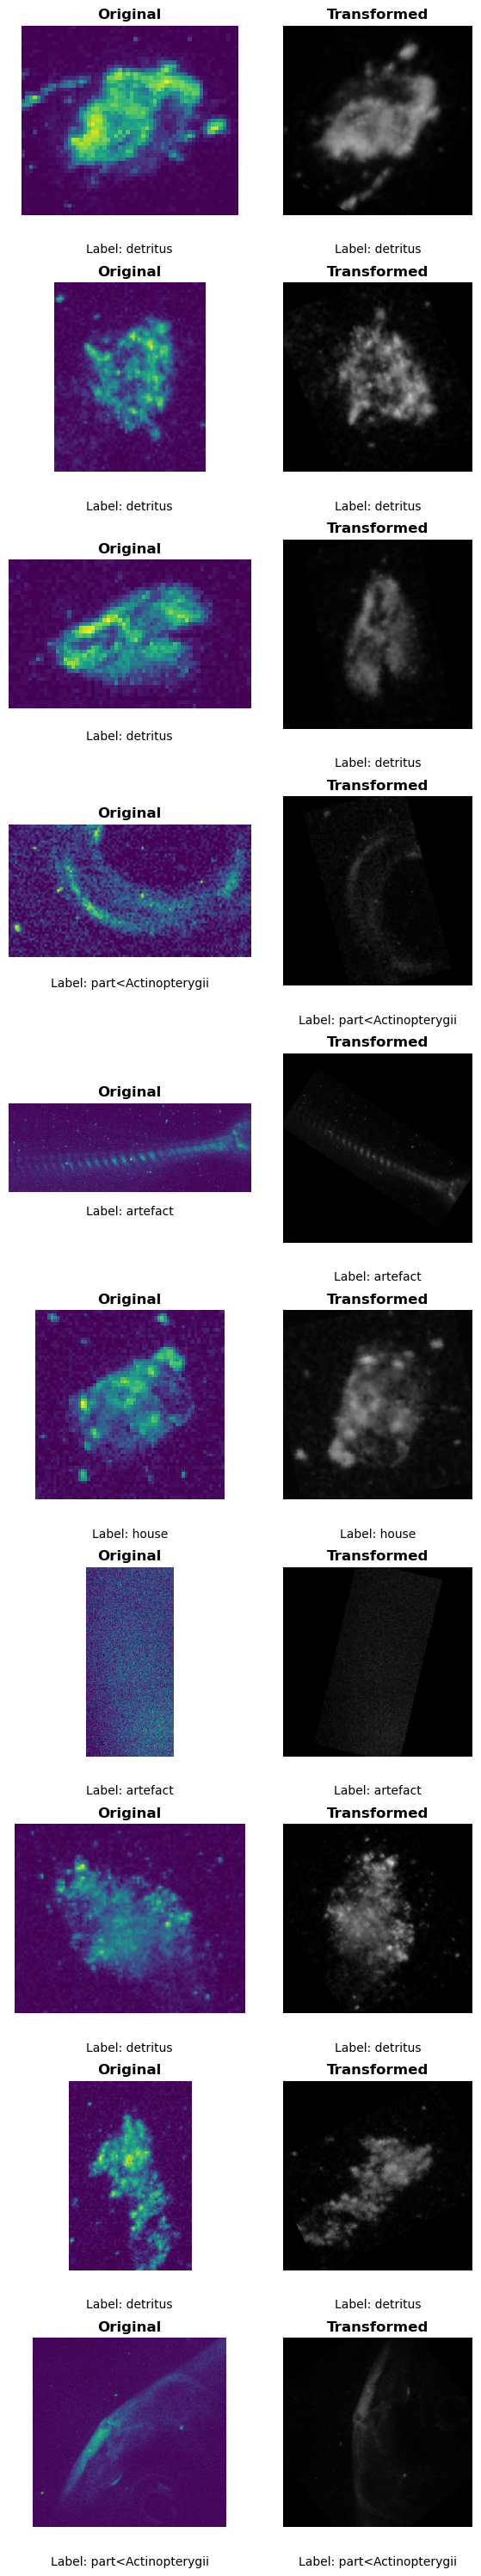

In [15]:
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as F
from torchvision.io import read_image

# Sélection aléatoire de 10 chemins d'images
sample_df = test_df.sample(10, random_state=42)
sample_paths = [os.path.join(data_dir, fname) for fname in sample_df["img_file_name"]]
sample_labels = sample_df["object_annotation_category"].tolist()

# Figure
fig, axes = plt.subplots(10, 2, figsize=(6, 30))

for i, (path, label) in enumerate(zip(sample_paths, sample_labels)):
    # Lecture de l'image brute
    img = read_image(path)
    img_before = F.to_pil_image(img)

    # Transformation
    img_after = F.to_pil_image(train_transform(img))

    # Original
    axes[i, 0].imshow(img_before)
    axes[i, 0].set_title("Original", fontsize=12, fontweight='bold')
    axes[i, 0].text(
        0.5, -0.15, f"Label: {label}",
        fontsize=10, ha='center', va='top', transform=axes[i, 0].transAxes
    )
    axes[i, 0].axis("off")

    # Transformée
    axes[i, 1].imshow(img_after)
    axes[i, 1].set_title("Transformed", fontsize=12, fontweight='bold')
    axes[i, 1].text(
        0.5, -0.15, f"Label: {label}",
        fontsize=10, ha='center', va='top', transform=axes[i, 1].transAxes
    )
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

## Dataloading

In [6]:
# ---Define batch size
batch_size = 32
n_cores = 8 #To adapt to the GPU capacity

log.info(f'Dataloading')

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cores, pin_memory=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cores, pin_memory=True)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cores, pin_memory=True)

# ---Print infos
print(f"Number of classes : {len(class_to_idx)}")
print(f"Number of classes in the valid set : {len(np.unique(val_labels))}")
print(f"Classes examples : {list(class_to_idx.keys())[:5]}")
print(f"Train batches : {len(train_dataloader)}, Val batches : {len(val_dataloader)}, Test batches : {len(test_dataloader)}")

# ---Create Dataloaders
dataloaders = {
    'train': train_dataloader,
    'valid': val_dataloader,
    'test': test_dataloader 
}

class_names = list(class_to_idx.keys())
n_classes= len(class_to_idx)

2025-12-16T15:45:59.891	Dataloading
2025-12-16T15:45:59.891	Dataloading


Number of classes : 29
Number of classes in the valid set : 24
Classes examples : ['Actinopterygii', 'Amphipoda', 'Annelida', 'Brachyura', 'Chaetognatha']
Train batches : 2310, Val batches : 894, Test batches : 472


## Check the completness of your dataset

In [9]:
import os

def check_dataset_paths(dataset, name="dataset", max_display=5):
    """
    Vérifie que tous les chemins d'images du dataset existent.
    Affiche un résumé et quelques exemples de fichiers manquants.
    """
    print(f"🔍 Vérification des chemins pour {name} ...")

    missing = [p for p in dataset.paths if not os.path.exists(p)]

    if len(missing) == 0:
        print(f"✅ Tous les fichiers du {name} existent ({len(dataset.paths)} fichiers).")
    else:
        print(f"❌ {len(missing)} fichiers manquants sur {len(dataset.paths)} dans {name}.")
        print("Exemples de fichiers introuvables :")
        for p in missing[:max_display]:
            print("  -", p)
        print("💡 Vérifie ton data_dir ou la structure de tes chemins relatifs.")


In [11]:
check_dataset_paths(train_dataset, "train_dataset")
check_dataset_paths(val_dataset, "val_dataset")
check_dataset_paths(test_dataset, "test_dataset")

🔍 Vérification des chemins pour train_dataset ...
✅ Tous les fichiers du train_dataset existent (61521 fichiers).
🔍 Vérification des chemins pour val_dataset ...
✅ Tous les fichiers du val_dataset existent (14910 fichiers).
🔍 Vérification des chemins pour test_dataset ...
✅ Tous les fichiers du test_dataset existent (8819 fichiers).


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def log_confusion_matrix(model, dataloader, device, class_names, run_name="confusion_matrix"):
    
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(n_classes), normalize="true")
    
    # --- Save CSV version
    cm_path = "confusion_matrix.csv"
    np.savetxt(cm_path, cm, delimiter=",", fmt="%d")
    mlflow.log_artifact(cm_path)

    # --- Plot confusion matrix
    fig, ax = plt.subplots(figsize=(22, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format='.2f')
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(fontsize=8)
    plt.title("Confusion Matrix", fontsize=16)

    # Save PNG
    fig_path = "confusion_matrix.png"
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.close()

    mlflow.log_artifact(fig_path)

    print("✅ Confusion matrix logged to MLflow")


# Start MLflow Run fine tuning

In [7]:
print("torch.cuda.is_available():", torch.cuda.is_available())
print("Nombre de GPU:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Nom GPU:", torch.cuda.get_device_name(0))

torch.cuda.is_available(): True
Nombre de GPU: 1
Nom GPU: NVIDIA RTX 6000 Ada Generation


## Creation d'un "GridSearch" à la mano

In [10]:
search_space = {
    "learning_rate": ["AUTO/10"],# AUTO = use opti_lr[0.95, 0.5]
    "scheduler_gamma": [1,2],
    "sensitivity":[0.5],
    "gamma":[1]
    
}

import itertools

def grid_search(space):
    keys = space.keys()
    for values in itertools.product(*space.values()):
        yield dict(zip(keys, values))

## Launch experimentation

2025-12-16T23:31:12.173	Initializing mobilenet_v3_large + one_layer for LR search…
2025-12-16T23:31:12.173	Initializing mobilenet_v3_large + one_layer for LR search…


Running LR Finder...


  0%|          | 0/120 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
Suggested learning rate: 1.44e-04
LR suggestion: steepest gradient
Suggested LR: 1.79E-04


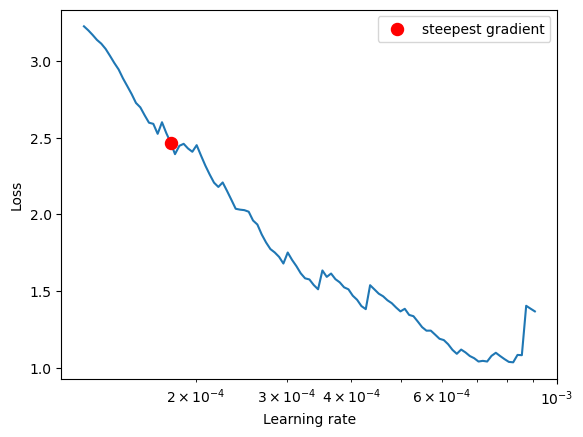

2025-12-16T23:31:18.083	Optimal LR for mobilenet_v3_large+one_layer: 1.44e-04
2025-12-16T23:31:18.083	Optimal LR for mobilenet_v3_large+one_layer: 1.44e-04
2025-12-16T23:31:18.115	Training mobilenet_v3_large with one_layer, lr=1.444321464727281e-05
2025-12-16T23:31:18.115	Training mobilenet_v3_large with one_layer, lr=1.444321464727281e-05
2025-12-16T23:31:18.149	Removed existing checkpoint: /home/coicaudtou/myspace/Classify_ANERIS/Outputs/output_training/Phase4_mobilenet_v3_large_one_layer_scheduler_1_CrossEntropyLoss_best.pt
2025-12-16T23:31:18.149	Removed existing checkpoint: /home/coicaudtou/myspace/Classify_ANERIS/Outputs/output_training/Phase4_mobilenet_v3_large_one_layer_scheduler_1_CrossEntropyLoss_best.pt
2025-12-16T23:31:18.384	Start training
2025-12-16T23:31:18.384	Start training
  0%|          | 0/10 [00:00<?, ?it/s]2025-12-16T23:31:18.554	Epoch 1/10
2025-12-16T23:31:18.554	Epoch 1/10
2025-12-16T23:31:19.219	Warning: Some classes do not exist in the target. F1 scores for th

In [ ]:
mlflow.set_experiment("Phase4_training_on_14401+14402")

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

models_to_train = ["mobilenet_v3_large", "efficientnet_v2", "pyramidnet", "resnet50"]
architectures = ["one_layer"]
criterions = ["CrossEntropyLoss", "FocalLoss"]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for model_name in models_to_train:
    for arch in architectures:
        for crit in criterions:
            for params in grid_search(search_space):
                
                weight_sensitivity = params["sensitivity"]
                class_weights = ((max_count / class_counts)**weight_sensitivity).to_numpy()

                gamma_loss = params["gamma"]
    
                log.info(f"Initializing {model_name} + {arch} for LR search…")
                # ---- Build temporary model to run LR finder
                tmp_model = initialize_model(
                    model_name, n_classes, arch,
                    target_params=600000,
                    activation_fct=nn.Hardswish(),
                    p_dropout=0.2  # neutral value
                ).to(device)
        
                tmp_optimizer = torch.optim.Adam(tmp_model.parameters(), lr=1e-4)

                if crit == "CrossEntropyLoss":
                    tmp_criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float().to(device))
                else: 
                    tmp_criterion = FocalLoss(
                        gamma=gamma_loss,
                        alpha=torch.tensor(class_weights).float().to(device),
                        reduction='mean'
                    )
        
                opti_lr = find_optimal_lr(
                    tmp_model, train_dataloader, tmp_criterion,
                    tmp_optimizer, device,
                    end_lr=0.001, num_iter=120
                )
        
                log.info(f"Optimal LR for {model_name}+{arch}: {opti_lr:.2e}")
        
                # -------------------------------------------------------------
                #    GRID SEARCH
                # -------------------------------------------------------------
    
                lr = opti_lr / 10 if params["learning_rate"] == "AUTO/10" else opti_lr
    
                gamma = params["scheduler_gamma"]
                step = 5 if gamma == 0.5 else 1
                
                # ---------------------------------------------------------
                #       MLflow: TRAIN MODEL FOR THIS COMBINATION
                # --------------------------------------------------------
            
                with mlflow.start_run(run_name=f"{model_name}_{arch}", nested=True):
                    
                    log.info(f"Training {model_name} with {arch}, lr={lr}")
    
                    #--- Empty memory
                    if 'model' in locals():
                        del model
                    if 'optimizer' in locals():
                        del optimizer
                    if 'criterion' in locals():
                        del criterion
                    torch.cuda.empty_cache()
    
                    #--- Where to save the best model 
                    best_model_path = os.path.join(
                        train_dir,
                        f"Phase4_{model_name}_{arch}_scheduler_{gamma}_{crit}_best.pt"
                    )
    
                    #Delete if already exist
                    if os.path.exists(best_model_path):
                        os.remove(best_model_path)
                        log.info(f"Removed existing checkpoint: {best_model_path}")
                
                    # --- Initialize model
                    model = initialize_model(model_name, n_classes, arch, target_params=600000, activation_fct=nn.Hardswish(), p_dropout=0.2)
                    model = model.to(device)
                    
                    num_epochs=10
        
                    # --- Define a loss function and the optimizer 
                    if crit == "CrossEntropyLoss":
                        criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float().to(device))
                    else: 
                        criterion = FocalLoss(
                            gamma=gamma_loss,
                            alpha=torch.tensor(class_weights).float().to(device),
                            reduction='mean'
                        )
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                    
                    # --- scheduler 
                    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=gamma)
                
                    # --- Log hyperparameters
                    mlflow.log_params({
                        "model": model_name,
                        "architecture": arch,
                        "dataset": "14401+14402",
                        "batch_size": batch_size,
                        "learning_rate": lr,
                        "type_of_lr": params["learning_rate"],
                        "num_epochs": num_epochs,
                        "optimizer": "Adam",
                        "dropout": 0.2,
                        "scheduler_gamma": gamma,
                        "size_step": step,
                        "sensitivity": weight_sensitivity,
                        "loss_criterion": crit,
                        "gamma_of_focalloss": gamma_loss
                    })
        
                    if torch.cuda.is_available():
                        mlflow.log_param("gpu_name", torch.cuda.get_device_name(0))
                        mlflow.log_param("cuda_version", torch.version.cuda)
                
                    # ----------------- Train -----------------
                    classes_to_remove = ["detritus", "filament<detritus", "artefact", "reflection", "dark<sphere", "Actinopterygii"]
                    # --- Train model
                    train_model(model, dataloaders, criterion, scheduler, optimizer, best_model_path, class_to_idx, classes_to_remove, n_classes, device, num_epochs=10, artf_path=model_name)
            
                    # --- Log the trained model AFTER training
                    mlflow.pytorch.log_model(
                        model,
                        artifact_path=model_name
                    )
    
                    log_confusion_matrix(
                        model=model,
                        dataloader=val_dataloader,
                        device=device,
                        class_names=list(class_to_idx.keys()),
                        n_classes = n_classes,
                        base_dir=base_dir
                    )
                    log.info(f"Training complete and logged for {model_name}")


# Load the model

In [ ]:
client = mlflow.tracking.MlflowClient()

runs = client.search_runs(
    experiment_ids=[experiment_id],
    order_by=["metrics.val_f1 DESC"]
)

best_run = runs[0]
print("Best run:", best_run.info.run_id)

## Estimation du nomnbre de paramètres par modèle

In [ ]:
# Fonction pour compter les paramètres
def count_parameters(model, trainable_only=True):
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

models_to_train = ["mobilenet_v3_large", "resnet50", "efficientnet_v2", "pyramidnet"]
architectures = ["two_layers"]

for model_name in models_to_train:

    model = initialize_model(model_name, n_classes, "two_layers", target_params=600000, activation_fct=nn.Hardswish(), p_dropout=0.2)
    print(f"Paramètres entraînables {model_name} : {count_parameters(model, trainable_only=True)}")
    print(f"Paramètres totaux {model_name} : {count_parameters(model, trainable_only=False)}")

